# Useful extensions to optimisation problem 

There are some some extensions to the optimisation problem that can be configured. This notebook describes three extensions and shows their effects on optimisation results.

1. **Spatial Lag**
- This allows you to include neighboring zones when calculating values for a zone

2. **Population Weighted Objectives**
- Objective functions can be weighted by population. Unweighted objectives treat all zones equally, which is not a true reflection of travel demand

3. **Penalty Method with Constraint Handling**
- The solution space is huge, and many solutions are infeasible. A penalty method can be used to guide the search towards feasible solutions. This is done by adding a penalty to the objective function for each constraint violation. The penalty weight can be adjusted adaptively during the optimisation process.


## Setting up the data

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from typing import Dict, Any
import logging

# Add src to path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

In [2]:
# =============================================================================
# Data Setup and Problem Configuration
# =============================================================================

from transit_opt.preprocessing.prepare_gtfs import GTFSDataPreparator
from transit_opt.optimisation.spatial.boundaries import StudyAreaBoundary

print("=== LOADING GTFS DATA ===")

# Create GTFS preparator
preparator = GTFSDataPreparator(
    gtfs_path='../data/external/study_area_gtfs_bus.zip',
    interval_hours=6,  # 4 periods per day
    date=None,  # Use full GTFS feed
    turnaround_buffer=1.15,  # 15% buffer
    max_round_trip_minutes=240.0,  # Maximum round-trip time
    no_service_threshold_minutes=480.0,  # Threshold for no-service mapping
)

# Define allowed headways for optimization
allowed_headways = [10, 15, 30, 60, 120, 240] # in minutes

print(f"📋 Allowed headways: {allowed_headways} minutes")
print("🔄 Extracting optimization data...")

# Extract optimization data structure
opt_data = preparator.extract_optimization_data(allowed_headways)

print(f"\n✅ GTFS DATA PROCESSED:")
print(f"   📊 Routes: {opt_data['n_routes']}")
print(f"   ⏰ Time intervals: {opt_data['n_intervals']} (6h each)")
print(f"   🎯 Decision variables: {opt_data['decision_matrix_shape'][0]} × {opt_data['decision_matrix_shape'][1]} = {np.prod(opt_data['decision_matrix_shape'])}")
print(f"   🚗 Current peak fleet: {opt_data['constraints']['fleet_analysis']['total_current_fleet_peak']} vehicles")
print(f"   🔢 Headway choices: {opt_data['n_choices']} (including no-service)")

=== LOADING GTFS DATA ===
📋 Allowed headways: [10, 15, 30, 60, 120, 240] minutes
🔄 Extracting optimization data...


Route 73302: Round-trip 317.4min exceeds limit (240.0min), filtered out
Route 54721: Round-trip 366.8min exceeds limit (240.0min), filtered out
Route 30922: Round-trip 247.2min exceeds limit (240.0min), filtered out
Route 12490: Round-trip 416.3min exceeds limit (240.0min), filtered out
Route 37599: Round-trip 355.3min exceeds limit (240.0min), filtered out
Route 59129: Round-trip 396.7min exceeds limit (240.0min), filtered out
Route 73828: Round-trip 258.8min exceeds limit (240.0min), filtered out
Route 77159: Round-trip 954.5min exceeds limit (240.0min), filtered out
Route 74948: Round-trip 1069.5min exceeds limit (240.0min), filtered out
Route 57719: Round-trip 978.6min exceeds limit (240.0min), filtered out
Route 31952: Round-trip 569.2min exceeds limit (240.0min), filtered out
Route 77162: Round-trip 1207.5min exceeds limit (240.0min), filtered out
Route 47558: Round-trip 770.5min exceeds limit (240.0min), filtered out
Route 73397: Round-trip 586.5min exceeds limit (240.0min), fil


✅ GTFS DATA PROCESSED:
   📊 Routes: 147
   ⏰ Time intervals: 4 (6h each)
   🎯 Decision variables: 147 × 4 = 588
   🚗 Current peak fleet: 1250 vehicles
   🔢 Headway choices: 7 (including no-service)


In [3]:
# Load boundary geometry
boundary_gdf = gpd.read_file("../data/external/boundaries/study_area_boundary.geojson")
print(f"📍 Loaded boundary with {len(boundary_gdf)} feature(s)")

# Create study area boundary with buffer
study_boundary = StudyAreaBoundary(
    boundary_gdf=boundary_gdf,
    crs="EPSG:3857",  # Web Mercator for spatial analysis
    buffer_km=2.0     # 2km buffer around boundary
)

print(f"✅ Study area boundary created:")
print(f"   📐 CRS: {study_boundary.target_crs}")
print(f"   📏 Buffer: 2km")

📍 Loaded boundary with 2607 feature(s)
✅ Study area boundary created:
   📐 CRS: EPSG:3857
   📏 Buffer: 2km


## 1. **Spatial Neighbors**

The idea behind spatial the `spatial_lag` functionality (name is probably innaccurate) is that the objective value calculation is based on the sum / average of all zones. Depending on the zone size, you could say that the objective value for a zone should also consider the values of neighboring zones. For example, if we are using WaitingTime as an objective, and our zones our small, it is reasonable to say that a portion of the population may take a bus from a neighboring zone, and so the waiting time in neighboring zones should be considered when calculating the objective value for a zone. 

We use an alpha parameter to control the strength of the spatial lag. An alpha of 0 means no spatial lag, and an alpha of 1 means that the objective value for a zone is the average of the objective values of all neighboring zones. Values between 0 and 1 are a weighted average of the zone's own value and the average of its neighbors.


In [4]:
print("🌍 SPATIAL LAG FEATURE DEMONSTRATION")
print("="*60)
print("Spatial lag allows neighboring zones to influence objective calculations")
print()

# Create two configurations: one with spatial lag, one without
print("📋 Setting up spatial lag comparison...")

# Configuration WITHOUT spatial lag
config_no_spatial_lag = {
    'problem': {
        'objective': {
            'type': 'StopCoverageObjective',
            'spatial_resolution_km': 3.0,
            'crs': 'EPSG:3857',
            'boundary': study_boundary,
            'boundary_buffer_km': 2.0,
            'spatial_lag': False,  # No spatial lag
            'alpha': 0.0
        },
        'constraints': [
            {
                'type': 'FleetTotalConstraintHandler',
                'baseline': 'current_peak',
                'tolerance': 0.15,
                'measure': 'peak'
            },
            {
                'type': 'MinimumFleetConstraintHandler',
                'min_fleet_fraction': 0.8,  # Maintain X% of current service
                'level': 'system',
                'measure': 'peak',
                'baseline': 'current_peak'
            }
        ]
    },
    'optimization': {
        'algorithm': {
            'type': 'PSO',
            'pop_size': 20,
            'inertia_weight': 0.9,
            'inertia_weight_final': 0.4,
            'cognitive_coeff': 2.0,
            'social_coeff': 2.0,
            'use_penalty_method': True,
            'penalty_weight': 10.0,
            'adaptive_penalty': False
        },
        'termination': {
            'max_generations': 25
        },
        'monitoring': {
            'progress_frequency': 5,
            'save_history': True
        }
    }
}

# Configuration WITH spatial lag
config_with_spatial_lag = {
    'problem': {
        'objective': {
            'type': 'StopCoverageObjective',
            'spatial_resolution_km': 3.0,
            'crs': 'EPSG:3857',
            'boundary': study_boundary,
            'boundary_buffer_km': 2.0,
            'spatial_lag': True,   # ENABLE SPATIAL LAG
            'alpha': 0.3          # 30% spatial weighting
        },
        'constraints': [
            {
                'type': 'FleetTotalConstraintHandler',
                'baseline': 'current_peak',
                'tolerance': 0.15,
                'measure': 'peak'
            },
            {
                'type': 'MinimumFleetConstraintHandler',
                'min_fleet_fraction': 0.8,  # Maintain X% of current service
                'level': 'system',
                'measure': 'peak',
                'baseline': 'current_peak'
            }
        ]
    },
    'optimization': {
        'algorithm': {
            'type': 'PSO',
            'pop_size': 20,
            'inertia_weight': 0.9,
            'inertia_weight_final': 0.4,
            'cognitive_coeff': 2.0,
            'social_coeff': 2.0,
            'use_penalty_method': True,
            'penalty_weight': 10.0,
            'adaptive_penalty': False
        },
        'termination': {
            'max_generations': 25
        },
        'monitoring': {
            'progress_frequency': 5,
            'save_history': True
        }
    }
}

print("✅ Configurations created:")
# Alpha is not used if you don't set spatial_lag: True
print(f"   Without spatial lag: alpha = {config_no_spatial_lag['problem']['objective']['alpha']}")
print(f"   With spatial lag: alpha = {config_with_spatial_lag['problem']['objective']['alpha']}")

🌍 SPATIAL LAG FEATURE DEMONSTRATION
Spatial lag allows neighboring zones to influence objective calculations

📋 Setting up spatial lag comparison...
✅ Configurations created:
   Without spatial lag: alpha = 0.0
   With spatial lag: alpha = 0.3


### Running PSO with and without spatial lag

In [5]:
# Run optimization WITHOUT spatial lag
print("\n🔄 RUNNING OPTIMIZATION WITHOUT SPATIAL LAG")
print("="*50)

from transit_opt.optimisation.config.config_manager import OptimizationConfigManager
from transit_opt.optimisation.runners.pso_runner import PSORunner

config_manager_no_lag = OptimizationConfigManager(config_dict=config_no_spatial_lag)
pso_runner_no_lag = PSORunner(config_manager_no_lag)

print("Starting optimization without spatial lag...")
result_no_lag = pso_runner_no_lag.optimize(opt_data, track_best_n=3)

print(f"\n✅ Optimization without spatial lag completed:")
print(f"   Runtime: {result_no_lag.optimization_time:.1f} seconds")
print(f"   Best objective: {result_no_lag.best_objective:.6f}")
print(f"   Generations completed: {result_no_lag.generations_completed}")
print(f"   Feasible solution: {'✅' if result_no_lag.constraint_violations['feasible'] else '❌'}")

# Get detailed analysis
objective_no_lag = pso_runner_no_lag.problem.objective
analysis_no_lag = objective_no_lag.get_detailed_analysis(result_no_lag.best_solution)

print(f"   Zones with service: {analysis_no_lag['zones_with_service_average']}")
print(f"   Total vehicles (avg): {analysis_no_lag['total_vehicles_average']:.1f}")
print(f"   Coefficient of variation: {analysis_no_lag['coefficient_of_variation_average']:.3f}")


🔄 RUNNING OPTIMIZATION WITHOUT SPATIAL LAG
📋 Using provided configuration dictionary
Starting optimization without spatial lag...
✅ Spatial system ready: 251 hexagonal zones
n_gen  |  n_eval  |    f     |    S    |    w    |    c1    |    c2    |     f_avg     |     f_min    
     1 |       20 |        - |       - |  0.9000 |  2.00000 |  2.00000 |  7.865725E+05 |  4.464020E+05
     2 |       40 | -1.3E+00 |       3 |  0.0205 |  2.00000 |  2.01292 |  7.865725E+05 |  4.464020E+05
     3 |       60 | -1.3E+00 |       3 |  0.0205 |  1.99370 |  2.03143 |  7.865725E+05 |  4.464020E+05
     4 |       80 | -1.3E+00 |       3 |  0.0205 |  1.98157 |  2.04150 |  7.865725E+05 |  4.464020E+05
     5 |      100 | -1.3E+00 |       3 |  0.0205 |  1.97074 |  2.05314 |  7.865725E+05 |  4.464020E+05
     6 |      120 | -1.3E+00 |       3 |  0.0205 |  1.95982 |  2.06520 |  7.865725E+05 |  4.464020E+05
     7 |      140 | -1.3E+00 |       3 |  0.0205 |  1.94853 |  2.07491 |  7.865725E+05 |  4.464020E+05
 

In [6]:
# Run optimization WITH spatial lag
print("\n🔄 RUNNING OPTIMIZATION WITH SPATIAL LAG")
print("="*50)

config_manager_with_lag = OptimizationConfigManager(config_dict=config_with_spatial_lag)
pso_runner_with_lag = PSORunner(config_manager_with_lag)

print("Starting optimization with spatial lag...")
result_with_lag = pso_runner_with_lag.optimize(opt_data, track_best_n=3)

print(f"\n✅ Optimization with spatial lag completed:")
print(f"   Runtime: {result_with_lag.optimization_time:.1f} seconds")
print(f"   Best objective: {result_with_lag.best_objective:.6f}")
print(f"   Generations completed: {result_with_lag.generations_completed}")
print(f"   Feasible solution: {'✅' if result_with_lag.constraint_violations['feasible'] else '❌'}")

# Get detailed analysis
objective_with_lag = pso_runner_with_lag.problem.objective
analysis_with_lag = objective_with_lag.get_detailed_analysis(result_with_lag.best_solution)

print(f"   Zones with service: {analysis_with_lag['zones_with_service_average']}")
print(f"   Total vehicles (avg): {analysis_with_lag['total_vehicles_average']:.1f}")
print(f"   Coefficient of variation: {analysis_with_lag['coefficient_of_variation_average']:.3f}")


🔄 RUNNING OPTIMIZATION WITH SPATIAL LAG
📋 Using provided configuration dictionary
Starting optimization with spatial lag...
✅ Spatial system ready: 251 hexagonal zones, spatial lag (α=0.3)
n_gen  |  n_eval  |    f     |    S    |    w    |    c1    |    c2    |     f_avg     |     f_min    
     1 |       20 |        - |       - |  0.9000 |  2.00000 |  2.00000 |  8.414161E+05 |  5.080820E+05
     2 |       40 | -1.2E+00 |       3 |  0.0305 |  2.00000 |  2.01760 |  8.414161E+05 |  5.080820E+05
     3 |       60 |  0.33731 |       2 |  0.6157 |  2.03028 |  1.97411 |  8.400775E+05 |  5.080820E+05
     4 |       80 |  0.09255 |       3 |  0.4589 |  2.02767 |  1.98717 |  8.078462E+05 |  5.080820E+05
     5 |      100 | -1.1E-01 |       3 |  0.3365 |  2.01976 |  2.00471 |  7.955165E+05 |  5.080820E+05
     6 |      120 | -1.7E-01 |       3 |  0.3018 |  2.00738 |  2.01168 |  7.585268E+05 |  5.080820E+05
     7 |      140 | -2.7E-01 |       3 |  0.2469 |  1.99789 |  2.02192 |  7.533049E+05 | 

### Comparing results

The results for any objective function will be different id you use spatial lag, as zone neighbors influence the statistic of a zone. The overall objective being higher or lower with spatial lag is not an indication of a better solution, just a different approach to calculating

What does this mean?

- Only compare solutions from the same PSO run. Do not compare objective values from a run with spatial_lag to a run without spatial_lag. You can however compare the output network to see how spatial lag influences PT schedule
- `spatial_lag` is a nice option to have if you think people in a zone may be using buses from a neighboring zone. The size of the zone is a good indicator of this. 
- The value of `alpha` could be set based on size of zone (smaller zone = higher neighbor inflence). For big zones, you could also use `spatial_lag` but set a small `alpha`, as a small fraction of people living close to zone boundaries would make use of services in neigboring zones

In [7]:
# Compare spatial lag results
print("\n📊 SPATIAL LAG COMPARISON")
print("="*50)

print(f"{'Metric':<25} {'No Spatial Lag':<15} {'With Spatial Lag':<15} {'Difference':<15}")
print("-" * 70)

# Objective comparison
obj_diff = result_with_lag.best_objective - result_no_lag.best_objective
obj_pct = (obj_diff / result_no_lag.best_objective) * 100
print(f"{'Objective Value':<25} {result_no_lag.best_objective:<15.6f} {result_with_lag.best_objective:<15.6f} {obj_pct:<15.2f}%")

# Zones with service
zones_diff = analysis_with_lag['zones_with_service_average'] - analysis_no_lag['zones_with_service_average']
print(f"{'Zones w/ Service':<25} {analysis_no_lag['zones_with_service_average']:<15} {analysis_with_lag['zones_with_service_average']:<15} {zones_diff:<15}")

# Coefficient of variation
cv_diff = analysis_with_lag['coefficient_of_variation_average'] - analysis_no_lag['coefficient_of_variation_average']
print(f"{'Coeff. of Variation':<25} {analysis_no_lag['coefficient_of_variation_average']:<15.3f} {analysis_with_lag['coefficient_of_variation_average']:<15.3f} {cv_diff:<15.3f}")

# Vehicle usage
vehicles_diff = analysis_with_lag['total_vehicles_average'] - analysis_no_lag['total_vehicles_average']
print(f"{'Avg. Vehicles':<25} {analysis_no_lag['total_vehicles_average']:<15.1f} {analysis_with_lag['total_vehicles_average']:<15.1f} {vehicles_diff:<15.1f}")


📊 SPATIAL LAG COMPARISON
Metric                    No Spatial Lag  With Spatial Lag Difference     
----------------------------------------------------------------------
Objective Value           286875.543323   200923.510736   -29.96         %
Zones w/ Service          187             187             0              
Coeff. of Variation       1.467           1.455           -0.012         
Avg. Vehicles             6086.2          6752.0          665.8          



🗺️ SPATIAL LAG VISUALIZATION


/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128652 (\N{BUS}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREN

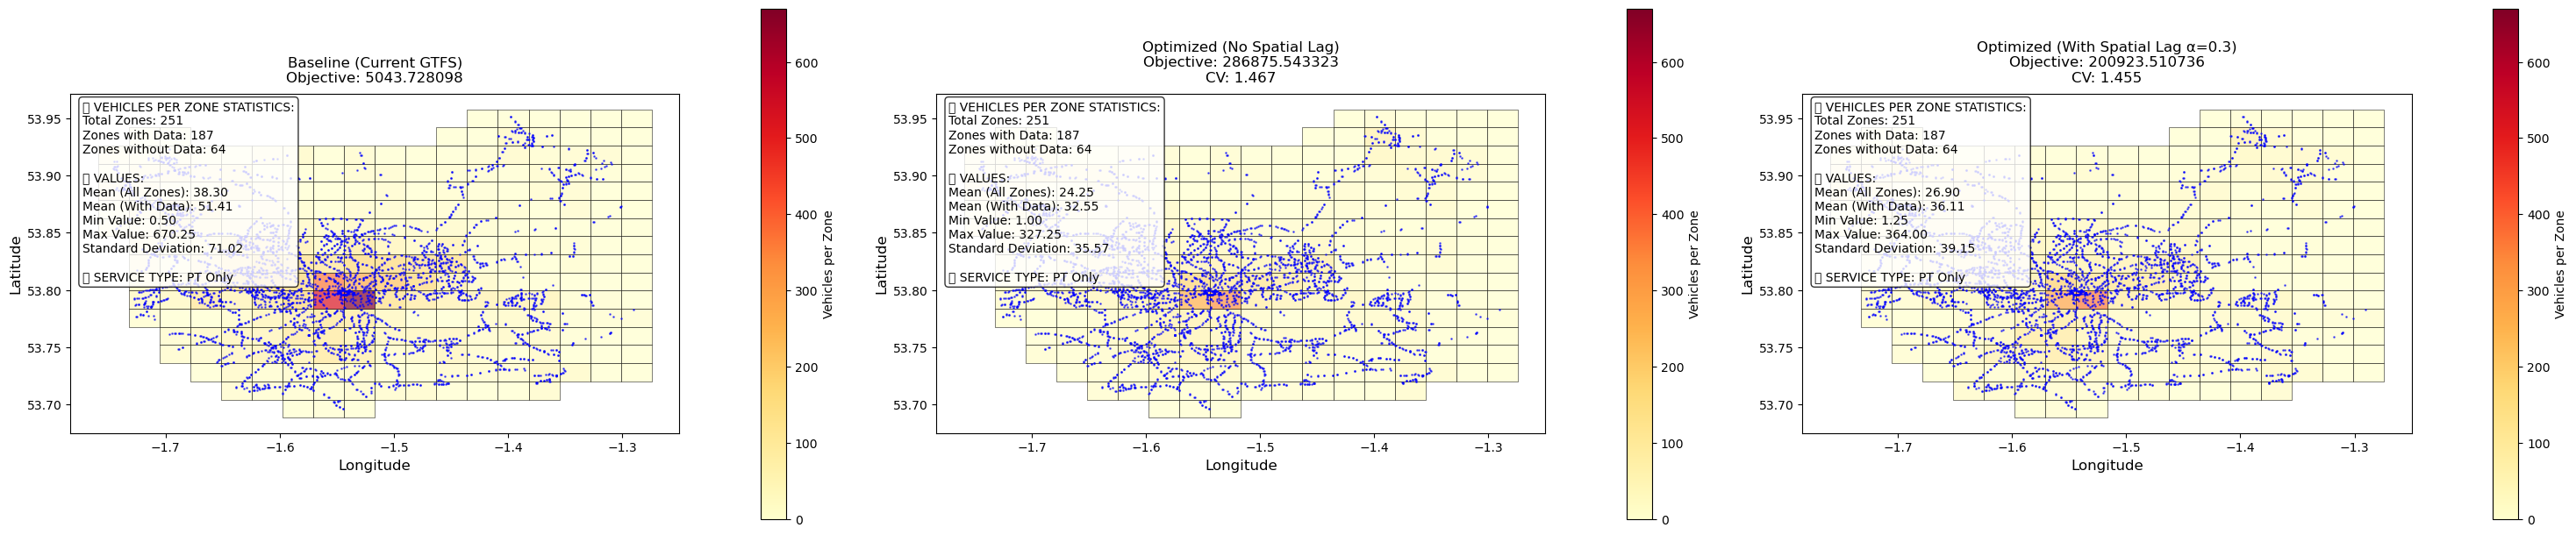


📖 SPATIAL LAG EXPLANATION:
   • Without spatial lag: Each zone optimized independently
   • With spatial lag: Zone values influenced by neighbors
   • Alpha parameter controls the spatial smoothing strength
   • Higher alpha = more spatial clustering/smoothing


In [8]:
# Visualize spatial lag comparison
print("\n🗺️ SPATIAL LAG VISUALIZATION")
print("="*50)

fig, axes = plt.subplots(1, 3, figsize=(30, 10))

# Plot 1: Baseline (current GTFS)
baseline_vehicles = objective_no_lag.spatial_system._vehicles_per_zone(
    opt_data['initial_solution'], opt_data
)["average"]

objective_no_lag.visualize(
    solution_matrix=opt_data['initial_solution'],
    ax=axes[0],
    show_stops=True,
    vmin=0,
    vmax=max(baseline_vehicles.max(),
             objective_no_lag.spatial_system._vehicles_per_zone(result_no_lag.best_solution, opt_data)["average"].max(),
             objective_with_lag.spatial_system._vehicles_per_zone(result_with_lag.best_solution, opt_data)["average"].max())
)
axes[0].set_title(f"Baseline (Current GTFS)\nObjective: {objective_no_lag.evaluate(opt_data['initial_solution']):.6f}",
                  fontsize=12, pad=10)

# Plot 2: Without spatial lag
objective_no_lag.visualize(
    solution_matrix=result_no_lag.best_solution,
    ax=axes[1],
    show_stops=True,
    vmin=0,
    vmax=max(baseline_vehicles.max(),
             objective_no_lag.spatial_system._vehicles_per_zone(result_no_lag.best_solution, opt_data)["average"].max(),
             objective_with_lag.spatial_system._vehicles_per_zone(result_with_lag.best_solution, opt_data)["average"].max())
)
axes[1].set_title(f"Optimized (No Spatial Lag)\nObjective: {result_no_lag.best_objective:.6f}\nCV: {analysis_no_lag['coefficient_of_variation_average']:.3f}",
                  fontsize=12, pad=10)

# Plot 3: With spatial lag
objective_with_lag.visualize(
    solution_matrix=result_with_lag.best_solution,
    ax=axes[2],
    show_stops=True,
    vmin=0,
    vmax=max(baseline_vehicles.max(),
             objective_no_lag.spatial_system._vehicles_per_zone(result_no_lag.best_solution, opt_data)["average"].max(),
             objective_with_lag.spatial_system._vehicles_per_zone(result_with_lag.best_solution, opt_data)["average"].max())
)
axes[2].set_title(f"Optimized (With Spatial Lag α=0.3)\nObjective: {result_with_lag.best_objective:.6f}\nCV: {analysis_with_lag['coefficient_of_variation_average']:.3f}",
                  fontsize=12, pad=10)

plt.tight_layout()
plt.show()

print(f"\n📖 SPATIAL LAG EXPLANATION:")
print(f"   • Without spatial lag: Each zone optimized independently")
print(f"   • With spatial lag: Zone values influenced by neighbors")
print(f"   • Alpha parameter controls the spatial smoothing strength")
print(f"   • Higher alpha = more spatial clustering/smoothing")

## 2. Population weighting

Our (existing) objective functions calculate total or variance in zonal statistics, but they treat all zones equally. this is unrealistic as it does not factor in travel demand

To better represent travel demand, we can use population density to weight these objectives. In the future, we can use more complex weighting like an OD matrix (from an activity-based model) that shows actual demand patterns

### Load Population Data

We use WorldPop data for population weighting. You can find national datasets at https://www.worldpop.org/

There are two options:
1. 1km resolution data
2. 100m resolution data

I am using the 1km raster layer. The 100m layer has a lot of 0 and negative values, so it is worth understanding this better before using it.


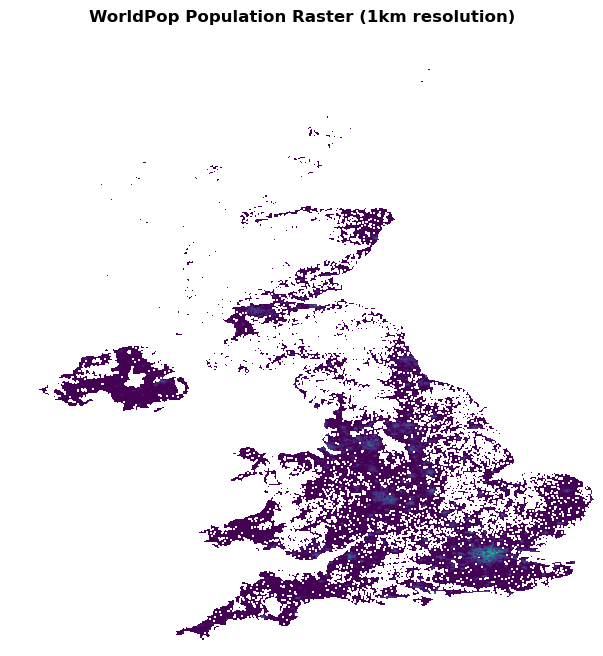

In [9]:
# Plot the raster layer
worldpop_path = "../data/external/population/gbr_pop_2025_CN_1km_R2025A_UA_v1.tif"

# Plot a very simple map of the raster layer on its own
import rasterio
from rasterio.plot import show

with rasterio.open(worldpop_path) as src:
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    show(src, ax=ax, title="WorldPop Population Raster (1km resolution)")
    ax.set_axis_off()
    plt.show()

### Set up configs

In [10]:
print("🌍 POPULATION WEIGHTING DEMONSTRATION")
print("="*60)
print()

# Create two configurations: one with population weighting and one without
print("📋 Setting up pop weighting comparison...")

# Configuration WITHOUT spatial lag
config_no_pop_weight = {
    'problem': {
        'objective': {
            'type': 'StopCoverageObjective',
            'spatial_resolution_km': 3.0,
            'crs': 'EPSG:3857',
            'boundary': study_boundary,
            'boundary_buffer_km': 2.0,
            'spatial_lag': False,  # No spatial lag
            'population_weighted': False
        },
        'constraints': [
            {
                'type': 'FleetTotalConstraintHandler',
                'baseline': 'current_peak',
                'tolerance': 0.15,
                'measure': 'peak'
            },
            {
                'type': 'MinimumFleetConstraintHandler',
                'min_fleet_fraction': 0.8,  # Maintain X% of current service
                'level': 'system',
                'measure': 'peak',
                'baseline': 'current_peak'
            }
        ]
    },
    'optimization': {
        'algorithm': {
            'type': 'PSO',
            'pop_size': 20,
            'inertia_weight': 0.9,
            'inertia_weight_final': 0.4,
            'cognitive_coeff': 2.0,
            'social_coeff': 2.0,
            'use_penalty_method': True,
            'penalty_weight': 10.0,
            'adaptive_penalty': False
        },
        'termination': {
            'max_generations': 25
        },
        'monitoring': {
            'progress_frequency': 5,
            'save_history': True
        }
    }
}

# Configuration WITH spatial lag
config_pop_weight = {
    'problem': {
        'objective': {
            'type': 'StopCoverageObjective',
            'spatial_resolution_km': 3.0,
            'crs': 'EPSG:3857',
            'boundary': study_boundary,
            'boundary_buffer_km': 2.0,
            'spatial_lag': False,
            'population_weighted': True,
            'population_layer': worldpop_path
        },
        'constraints': [
            {
                'type': 'FleetTotalConstraintHandler',
                'baseline': 'current_peak',
                'tolerance': 0.15,
                'measure': 'peak'
            },
            {
                'type': 'MinimumFleetConstraintHandler',
                'min_fleet_fraction': 0.8,  # Maintain X% of current service
                'level': 'system',
                'measure': 'peak',
                'baseline': 'current_peak'
            }
        ]
    },
    'optimization': {
        'algorithm': {
            'type': 'PSO',
            'pop_size': 20,
            'inertia_weight': 0.9,
            'inertia_weight_final': 0.4,
            'cognitive_coeff': 2.0,
            'social_coeff': 2.0,
            'use_penalty_method': True,
            'penalty_weight': 10.0,
            'adaptive_penalty': False
        },
        'termination': {
            'max_generations': 25
        },
        'monitoring': {
            'progress_frequency': 5,
            'save_history': True
        }
    }
}

🌍 POPULATION WEIGHTING DEMONSTRATION

📋 Setting up pop weighting comparison...


### Run PSO with and without population weighting

In [11]:
# Run optimization WITH pop weighting
print("\n🔄 RUNNING OPTIMIZATION WITH SPATIAL LAG")
print("="*50)

config_manager_with_pop = OptimizationConfigManager(config_dict=config_pop_weight)
pso_runner_with_pop = PSORunner(config_manager_with_pop)

print("Starting optimization with population weighting...")
result_with_pop = pso_runner_with_pop.optimize(opt_data, track_best_n=3)

print(f"\n✅ Optimization with pop weighting completed:")
print(f"   Runtime: {result_with_pop.optimization_time:.1f} seconds")
print(f"   Best objective: {result_with_pop.best_objective:.6f}")
print(f"   Generations completed: {result_with_pop.generations_completed}")
print(f"   Feasible solution: {'✅' if result_with_pop.constraint_violations['feasible'] else '❌'}")

# Get detailed analysis
objective_with_pop = pso_runner_with_pop.problem.objective
analysis_with_pop = objective_with_pop.get_detailed_analysis(result_with_pop.best_solution)

print(f"   Zones with service: {analysis_with_pop['zones_with_service_average']}")
print(f"   Total vehicles (avg): {analysis_with_pop['total_vehicles_average']:.1f}")
print(f"   Coefficient of variation: {analysis_with_pop['coefficient_of_variation_average']:.3f}")


🔄 RUNNING OPTIMIZATION WITH SPATIAL LAG
📋 Using provided configuration dictionary
Starting optimization with population weighting...


⚠️ CRS mismatch: Raster EPSG:4326 != VectorEPSG:3857


✅ Spatial system ready: 251 hexagonal zones, population weighted [PLACEHOLDER]
n_gen  |  n_eval  |    f     |    S    |    w    |    c1    |    c2    |     f_avg     |     f_min    
     1 |       20 |        - |       - |  0.9000 |  2.00000 |  2.00000 |  8.209087E+05 |  4.956678E+05
     2 |       40 | -1.0E+00 |       3 |  0.0435 |  2.00000 |  2.02062 |  8.209087E+05 |  4.956678E+05
     3 |       60 |  0.38702 |       2 |  0.6458 |  2.02496 |  1.98018 |  8.196794E+05 |  4.956678E+05
     4 |       80 |  0.03430 |       3 |  0.4216 |  2.02208 |  1.99185 |  7.841475E+05 |  4.821214E+05
     5 |      100 | -1.2E-01 |       3 |  0.3284 |  2.01487 |  2.00157 |  7.517416E+05 |  4.821202E+05
     6 |      120 | -2.1E-01 |       3 |  0.2809 |  2.00653 |  2.01201 |  7.450742E+05 |  4.821202E+05
     7 |      140 | -2.1E-01 |       3 |  0.2773 |  1.99732 |  2.02300 |  7.333219E+05 |  3.338684E+05
     8 |      160 | -1.6E-01 |       3 |  0.3045 |  1.98751 |  2.04047 |  7.211978E+05 |  3.33868

In [12]:
# Run optimization WITHOUT pop weighting
print("\n🔄 RUNNING OPTIMIZATION WITHOUT POPULATION WEIGHTING")
print("="*50)

config_manager_without_pop = OptimizationConfigManager(config_dict=config_no_pop_weight)
pso_runner_without_pop = PSORunner(config_manager_without_pop)

print("Starting optimization without pop weighting...")
result_without_pop = pso_runner_without_pop.optimize(opt_data, track_best_n=3)

print(f"\n✅ Optimization without pop weighting completed:")
print(f"   Runtime: {result_without_pop.optimization_time:.1f} seconds")
print(f"   Best objective: {result_without_pop.best_objective:.6f}")
print(f"   Generations completed: {result_without_pop.generations_completed}")
print(f"   Feasible solution: {'✅' if result_without_pop.constraint_violations['feasible'] else '❌'}")

# Get detailed analysis
objective_without_pop = pso_runner_without_pop.problem.objective
analysis_without_pop = objective_without_pop.get_detailed_analysis(result_without_pop.best_solution)

print(f"   Zones with service: {analysis_without_pop['zones_with_service_average']}")
print(f"   Total vehicles (avg): {analysis_without_pop['total_vehicles_average']:.1f}")
print(f"   Coefficient of variation: {analysis_without_pop['coefficient_of_variation_average']:.3f}")


🔄 RUNNING OPTIMIZATION WITHOUT POPULATION WEIGHTING
📋 Using provided configuration dictionary
Starting optimization without pop weighting...
✅ Spatial system ready: 251 hexagonal zones
n_gen  |  n_eval  |    f     |    S    |    w    |    c1    |    c2    |     f_avg     |     f_min    
     1 |       20 |        - |       - |  0.9000 |  2.00000 |  2.00000 |  8.363781E+05 |  6.111945E+05
     2 |       40 | -1.2E+00 |       3 |  0.0262 |  2.00000 |  2.02026 |  8.363781E+05 |  6.111945E+05
     3 |       60 | -1.2E+00 |       3 |  0.0262 |  1.99014 |  2.03658 |  8.363781E+05 |  6.111945E+05
     4 |       80 | -1.2E+00 |       3 |  0.0262 |  1.97726 |  2.04371 |  8.363781E+05 |  6.111945E+05
     5 |      100 | -1.2E+00 |       3 |  0.0262 |  1.96767 |  2.05967 |  8.363781E+05 |  6.111945E+05
     6 |      120 | -1.2E+00 |       3 |  0.0262 |  1.95515 |  2.07022 |  8.363781E+05 |  6.111945E+05
     7 |      140 | -1.2E+00 |       3 |  0.0262 |  1.94383 |  2.08019 |  8.363781E+05 |  6.1

In [13]:
# Compare spatial lag results
print("\n📊 POP WEIGHTING COMPARISON")
print("="*50)

print(f"{'Metric':<25} {'No Pop Weighting':<15} {'Pop Weighting':<15} {'Difference':<15}")
print("-" * 70)

# Objective comparison
obj_diff = result_with_pop.best_objective - result_without_pop.best_objective
obj_pct = (obj_diff / result_without_pop.best_objective) * 100
print(f"{'Objective Value':<25} {result_without_pop.best_objective:<15.6f} {result_with_pop.best_objective:<15.6f} {obj_diff:<15.2f}%")

# Zones with service
zones_diff = analysis_with_pop['zones_with_service_average'] - analysis_without_pop['zones_with_service_average']
print(f"{'Zones w/ Service':<25} {analysis_without_pop['zones_with_service_average']:<15} {analysis_with_pop['zones_with_service_average']:<15} {zones_diff:<15}")

# Coefficient of variation
cv_diff = analysis_with_pop['coefficient_of_variation_average'] - analysis_without_pop['coefficient_of_variation_average']
print(f"{'Coeff. of Variation':<25} {analysis_without_pop['coefficient_of_variation_average']:<15.3f} {analysis_with_pop['coefficient_of_variation_average']:<15.3f} {cv_diff:<15.3f}")

# Vehicle usage
vehicles_diff = analysis_with_pop['total_vehicles_average'] - analysis_without_pop['total_vehicles_average']
print(f"{'Avg. Vehicles':<25} {analysis_without_pop['total_vehicles_average']:<15.1f} {analysis_with_pop['total_vehicles_average']:<15.1f} {vehicles_diff:<15.1f}")


📊 POP WEIGHTING COMPARISON
Metric                    No Pop Weighting Pop Weighting   Difference     
----------------------------------------------------------------------
Objective Value           303885.475733   2865.794902     -301019.68     %
Zones w/ Service          187             187             0              
Coeff. of Variation       1.403           1.404           0.000          
Avg. Vehicles             6000.8          6471.8          471.0          



🗺️ POP WEIGHTING VISUALIZATION


/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128652 (\N{BUS}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREN

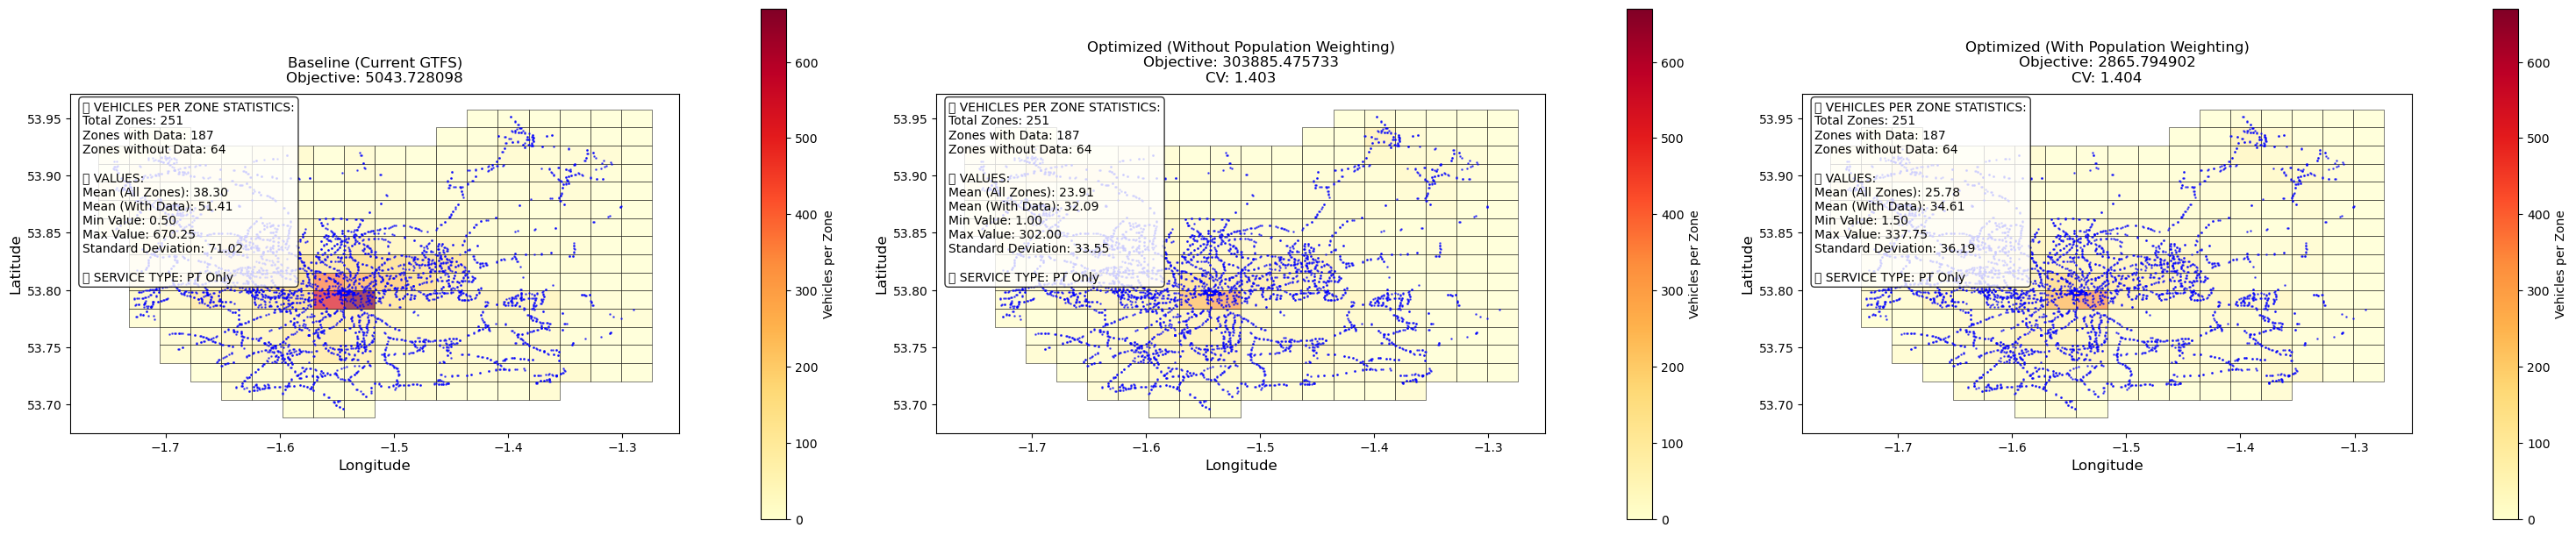

In [14]:
# Visualize population weighting comparison
print("\n🗺️ POP WEIGHTING VISUALIZATION")
print("="*50)

fig, axes = plt.subplots(1, 3, figsize=(30, 10))

# Plot 1: Baseline (current GTFS)
baseline_vehicles = objective_without_pop.spatial_system._vehicles_per_zone(
    opt_data['initial_solution'], opt_data
)["average"]

objective_without_pop.visualize(
    solution_matrix=opt_data['initial_solution'],
    ax=axes[0],
    show_stops=True,
    vmin=0,
    vmax=max(baseline_vehicles.max(),
             objective_without_pop.spatial_system._vehicles_per_zone(result_without_pop.best_solution, opt_data)["average"].max(),
             objective_with_pop.spatial_system._vehicles_per_zone(result_with_pop.best_solution, opt_data)["average"].max())
)
axes[0].set_title(f"Baseline (Current GTFS)\nObjective: {objective_without_pop.evaluate(opt_data['initial_solution']):.6f}",
                  fontsize=12, pad=10)

# Plot 2: Without spatial lag
objective_without_pop.visualize(
    solution_matrix=result_without_pop.best_solution,
    ax=axes[1],
    show_stops=True,
    vmin=0,
    vmax=max(baseline_vehicles.max(),
             objective_without_pop.spatial_system._vehicles_per_zone(result_without_pop.best_solution, opt_data)["average"].max(),
             objective_with_pop.spatial_system._vehicles_per_zone(result_with_pop.best_solution, opt_data)["average"].max())
)
axes[1].set_title(f"Optimized (Without Population Weighting)\nObjective: {result_without_pop.best_objective:.6f}\nCV: {analysis_without_pop['coefficient_of_variation_average']:.3f}",
                  fontsize=12, pad=10)

# Plot 3: With population weighting
objective_with_pop.visualize(
    solution_matrix=result_with_pop.best_solution,
    ax=axes[2],
    show_stops=True,
    vmin=0,
    vmax=max(baseline_vehicles.max(),
             objective_without_pop.spatial_system._vehicles_per_zone(result_without_pop.best_solution, opt_data)["average"].max(),
             objective_with_pop.spatial_system._vehicles_per_zone(result_with_pop.best_solution, opt_data)["average"].max())
)
axes[2].set_title(f"Optimized (With Population Weighting)\nObjective: {result_with_pop.best_objective:.6f}\nCV: {analysis_with_pop['coefficient_of_variation_average']:.3f}",
                  fontsize=12, pad=10)

plt.tight_layout()
plt.show()


## 3. Soft constraints using penalties

In our optimization problem, we set a number of constraints. We have two options for how to set these up

- HARD CONSTRAINTS (default): the solution is infeasible if it does not satisfy all constraints. The issue with this is that all infeasible solutions are treated equally, and the PSO does not really learn from the infeasible solution. We may end up with no feasible solutions if the constraints are very tight (feasible solutions are a tiny fraction of solution space)

- SOFT CONSTRAINTS: this allows the problem to learn from infeasible solutions. Instead of discarding infeasible solutions we penalise them. Their objective score is very bad, so PSO learns to explore a different direction

I RECOMMEND USING SOFT CONSTRAINTS TO BETTER GUIDE THE ALGORITHM. HARD CONSTRAINTS MAY NOT LEAD TO A FEASIBLE SOLUTION ESPECIALLY IF THE CONSTRAINTS ARE TIGHT

### Setting up the configs

We can set a global penalty for any infeasible solution, as well as specific penalties for violating specific constraints

- global penalty: this is defined by `penalty_weight`
- specific penalties: these are defined by `constraint_penalties`
- calculation: the penalty is added to the objective value. For example, if the objective value is 10, and the penalty is 5, the new objective value is 15
- how all penalties are added together: if a solution violates multiple constraints, the penalties are summed up and added to the objective value. Total penalty = global penalty + sum of constraint specific penalties

We have three constraints that we can specify:

- `FleetTotalConstraintHandler`: total fleet size should not exceed a baseline (e.g. current fleet size + x%). Initial fleet + (tolerance * initial fleet) = max fleet
- `MinimumFleetConstraintHandler`: minimum fleet size should be maintained (e.g. 80% of current fleet size). Initial fleet * min_fleet_fraction = min fleet
- `FleetPerIntervalConstraintHandler`: fleet size should not exceed a baseline for each time interval (e.g. current by interval). Use this to avoid having too many vehicles in one interval and not enough in another. The tolerance is the maximum increase allowed per interval, e.g. a tolerance of 0.3 means that the fleet size in any interval can be up to 30% higher than the baseline for that interval. 

In [15]:
print("⚖️ PENALTY METHOD vs HARD CONSTRAINTS COMPARISON")
print("="*60)
print("This compares two approaches to constraint handling:")
print("• Hard Constraints: Reject infeasible solutions completely")
print("• Penalty Method: Add constraint violations to objective function")
print()

# Create configurations for both approaches
config_hard_constraints = {
    'problem': {
        'objective': {
            'type': 'StopCoverageObjective',
            'spatial_resolution_km': 3.0,
            'crs': 'EPSG:3857',
            'boundary': study_boundary,
            'boundary_buffer_km': 2.0,
            'spatial_lag': False,
            'population_weighted': False
        },
        'constraints': [
            {
                'type': 'FleetTotalConstraintHandler',
                'baseline': 'current_peak',
                'tolerance': 0.25, # Initial fleet + (tolerance * initial fleet) = max fleet
                'measure': 'peak'
            },
            {
                'type': 'MinimumFleetConstraintHandler',
                'min_fleet_fraction': 0.7, # Maintain X% of current service
                'level': 'system',
                'measure': 'peak',
                'baseline': 'current_peak'
            },
            {
                'type': 'FleetPerIntervalConstraintHandler',
                'baseline': 'current_by_interval',
                'tolerance': 0.2, # Initial fleet + (tolerance * initial fleet) = max fleet   (Calculated per interval)
                'allow_borrowing': False
            }
        ]
    },
    'optimization': {
        'algorithm': {
            'type': 'PSO',
            'pop_size': 35,
            'inertia_weight': 0.9,
            'inertia_weight_final': 0.4,
            'cognitive_coeff': 2.0,
            'social_coeff': 2.0,
            'use_penalty_method': False  # HARD CONSTRAINTS
        },
        'termination': {
            'max_generations': 50
        },
        'monitoring': {
            'progress_frequency': 5,
            'save_history': True
        }
    }
}

config_penalty_method = {
    'problem': {
        'objective': {
            'type': 'StopCoverageObjective',
            'spatial_resolution_km': 3.0,
            'crs': 'EPSG:3857',
            'boundary': study_boundary,
            'boundary_buffer_km': 2.0,
            'spatial_lag': False,
            'population_weighted': False
        },
        'constraints': [
            {
                'type': 'FleetTotalConstraintHandler',
                'baseline': 'current_peak',
                'tolerance': 0.25,
                'measure': 'peak'
            },
            {
                'type': 'MinimumFleetConstraintHandler',
                'min_fleet_fraction': 0.7,
                'level': 'system',
                'measure': 'peak',
                'baseline': 'current_peak'
            },
            {
                'type': 'FleetPerIntervalConstraintHandler',
                'baseline': 'current_by_interval',
                'tolerance': 0.2,
                'allow_borrowing': False
            }
        ],
        'penalty_weights': {
            'fleet_total': 100.0,
            'minimum_fleet': 100.0
        }
    },
    'optimization': {
        'algorithm': {
            'type': 'PSO',
            'pop_size': 35,
            'inertia_weight': 0.9,
            'inertia_weight_final': 0.4,
            'cognitive_coeff': 2.0,
            'social_coeff': 2.0,
            'use_penalty_method': True,   # PENALTY METHOD
            'penalty_weight': 50.0, # Initial penalty weight
            'adaptive_penalty': False
        },
        'termination': {
            'max_generations': 50
        },
        'monitoring': {
            'progress_frequency': 5,
            'save_history': True
        }
    }
}

print("✅ Configurations created:")
print("   Hard Constraints: Direct constraint enforcement")
print("   Penalty Method: Constraint violations penalized in objective")

⚖️ PENALTY METHOD vs HARD CONSTRAINTS COMPARISON
This compares two approaches to constraint handling:
• Hard Constraints: Reject infeasible solutions completely
• Penalty Method: Add constraint violations to objective function

✅ Configurations created:
   Hard Constraints: Direct constraint enforcement
   Penalty Method: Constraint violations penalized in objective


### Running PSO with and without penalty method

In [16]:
# Run optimization with HARD CONSTRAINTS
print("\n🔄 RUNNING OPTIMIZATION WITH HARD CONSTRAINTS")
print("="*50)

config_manager_hard = OptimizationConfigManager(config_dict=config_hard_constraints)
pso_runner_hard = PSORunner(config_manager_hard)

print("Starting optimization with hard constraints...")
result_hard = pso_runner_hard.optimize(opt_data, track_best_n=3)

# Get detailed analysis
objective_hard = pso_runner_hard.problem.objective
analysis_hard = objective_hard.get_detailed_analysis(result_hard.best_solution)



🔄 RUNNING OPTIMIZATION WITH HARD CONSTRAINTS
📋 Using provided configuration dictionary
Starting optimization with hard constraints...
✅ Spatial system ready: 251 hexagonal zones
n_gen  |  n_eval  |    f     |    S    |    w    |    c1    |    c2    |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |       35 |        - |       - |  0.9000 |  2.00000 |  2.00000 |  9.800000E+01 |  1.713143E+02 |             - |             -
     2 |       70 | -4.7E-01 |       3 |  0.1653 |  2.00000 |  2.01769 |  9.800000E+01 |  1.713143E+02 |             - |             -
     3 |      105 | -4.7E-01 |       3 |  0.1653 |  1.99133 |  2.02875 |  9.800000E+01 |  1.713143E+02 |             - |             -
     4 |      140 | -4.7E-01 |       3 |  0.1653 |  1.98176 |  2.04378 |  9.800000E+01 |  1.713143E+02 |             - |             -
     5 |      175 | -4.7E-01 |       3 |  0.1653 |  1.96983 |  2.05748 |  9.800000E+01 |  1.713143E+02 |             - |             -
     6 |   

In [17]:
# Run optimization with PENALTY METHOD
print("\n🔄 RUNNING OPTIMIZATION WITH PENALTY METHOD")
print("="*50)

config_manager_penalty = OptimizationConfigManager(config_dict=config_penalty_method)
pso_runner_penalty = PSORunner(config_manager_penalty)

print("Starting optimization with penalty method...")
result_penalty = pso_runner_penalty.optimize(opt_data, track_best_n=3)


# Get detailed analysis
objective_penalty = pso_runner_penalty.problem.objective
analysis_penalty = objective_penalty.get_detailed_analysis(result_penalty.best_solution)


🔄 RUNNING OPTIMIZATION WITH PENALTY METHOD
📋 Using provided configuration dictionary
Starting optimization with penalty method...
✅ Spatial system ready: 251 hexagonal zones
n_gen  |  n_eval  |    f     |    S    |    w    |    c1    |    c2    |     f_avg     |     f_min    
     1 |       35 |        - |       - |  0.9000 |  2.00000 |  2.00000 |  2.955175E+06 |  4.833988E+05
     2 |       70 | -3.1E-01 |       3 |  0.2306 |  2.00000 |  2.01995 |  2.955175E+06 |  4.833988E+05
     3 |      105 |  0.48694 |       2 |  0.7028 |  2.01993 |  1.98504 |  2.904994E+06 |  4.833988E+05
     4 |      140 | -1.5E-02 |       3 |  0.3908 |  2.01704 |  2.00600 |  2.421614E+06 |  1.580492E+05
     5 |      175 | -6.4E-02 |       3 |  0.3607 |  2.00538 |  2.01956 |  1.674000E+06 |  5.572945E+04
     6 |      210 | -4.7E-02 |       3 |  0.3711 |  1.99308 |  2.03062 |  1.283569E+06 |  2.952875E+04
     7 |      245 | -4.0E-02 |       3 |  0.3756 |  1.98161 |  2.03901 |  1.138040E+06 |  1.243564E+03
 

In [18]:
# Compare constraint handling methods
print("\n📊 CONSTRAINT HANDLING COMPARISON")
print("="*50)

print(f"{'Metric':<25} {'Hard Constraints':<18} {'Penalty Method':<18} {'Difference':<15}")
print("-" * 80)

# Objective comparison (only compare if both are feasible)
if result_hard.constraint_violations['feasible'] and result_penalty.constraint_violations['feasible']:
    obj_diff = result_penalty.best_objective - result_hard.best_objective
    obj_pct = (obj_diff / result_hard.best_objective) * 100
    print(f"{'Objective Value':<25} {result_hard.best_objective:<18.6f} {result_penalty.best_objective:<18.6f} {obj_pct:<15.2f}%")
else:
    print(f"{'Objective Value':<25} {result_hard.best_objective:<18.6f} {result_penalty.best_objective:<18.6f} {'N/A (infeasible)':<15}")

# Feasibility comparison
hard_feasible = "✅ Yes" if result_hard.constraint_violations['feasible'] else "❌ No"
penalty_feasible = "✅ Yes" if result_penalty.constraint_violations['feasible'] else "❌ No"
print(f"{'Feasible Solution':<25} {hard_feasible:<18} {penalty_feasible:<18} {'-':<15}")

# Runtime comparison
runtime_diff = result_penalty.optimization_time - result_hard.optimization_time
runtime_pct = (runtime_diff / result_hard.optimization_time) * 100
print(f"{'Runtime (seconds)':<25} {result_hard.optimization_time:<18.1f} {result_penalty.optimization_time:<18.1f} {runtime_pct:<15.1f}%")

# Zones with service
zones_diff = analysis_penalty['zones_with_service_average'] - analysis_hard['zones_with_service_average']
print(f"{'Zones w/ Service':<25} {analysis_hard['zones_with_service_average']:<18} {analysis_penalty['zones_with_service_average']:<18} {zones_diff:<15}")

# Coefficient of variation
cv_diff = analysis_penalty['coefficient_of_variation_average'] - analysis_hard['coefficient_of_variation_average']
print(f"{'Coeff. of Variation':<25} {analysis_hard['coefficient_of_variation_average']:<18.3f} {analysis_penalty['coefficient_of_variation_average']:<18.3f} {cv_diff:<15.3f}")

# Vehicle usage
vehicles_diff = analysis_penalty['total_vehicles_average'] - analysis_hard['total_vehicles_average']
print(f"{'Avg. Vehicles':<25} {analysis_hard['total_vehicles_average']:<18.1f} {analysis_penalty['total_vehicles_average']:<18.1f} {vehicles_diff:<15.1f}")

# Generations completed
gen_diff = result_penalty.generations_completed - result_hard.generations_completed
print(f"{'Generations':<25} {result_hard.generations_completed:<18} {result_penalty.generations_completed:<18} {gen_diff:<15}")

print(f"\n💡 CONSTRAINT HANDLING INSIGHTS:")

# Check which method found better feasible solutions
if result_hard.constraint_violations['feasible'] and result_penalty.constraint_violations['feasible']:
    if result_penalty.best_objective < result_hard.best_objective:
        print(f"   ✅ Penalty method found better feasible solution")
    elif result_hard.best_objective < result_penalty.best_objective:
        print(f"   ✅ Hard constraints found better feasible solution")
    else:
        print(f"   ⚖️ Both methods found similar quality solutions")
elif result_penalty.constraint_violations['feasible'] and not result_hard.constraint_violations['feasible']:
    print(f"   ✅ Only penalty method found feasible solution")
elif result_hard.constraint_violations['feasible'] and not result_penalty.constraint_violations['feasible']:
    print(f"   ✅ Only hard constraints found feasible solution")
else:
    print(f"   ❌ Neither method found feasible solution")

# Comment on exploration vs exploitation
if result_penalty.optimization_time > result_hard.optimization_time:
    print(f"   ⏱️ Penalty method took longer (more exploration)")
else:
    print(f"   ⏱️ Hard constraints took longer (restricted search)")


📊 CONSTRAINT HANDLING COMPARISON
Metric                    Hard Constraints   Penalty Method     Difference     
--------------------------------------------------------------------------------
Objective Value           1390.874933        855.176700         -38.52         %
Feasible Solution         ✅ Yes              ✅ Yes              -              
Runtime (seconds)         27.7               37.0               33.6           %
Zones w/ Service          187                187                0              
Coeff. of Variation       1.429              1.297              -0.132         
Avg. Vehicles             6548.5             5657.5             -891.0         
Generations               50                 50                 0              

💡 CONSTRAINT HANDLING INSIGHTS:
   ✅ Penalty method found better feasible solution
   ⏱️ Penalty method took longer (more exploration)


### Visualise results


📈 CONVERGENCE COMPARISON


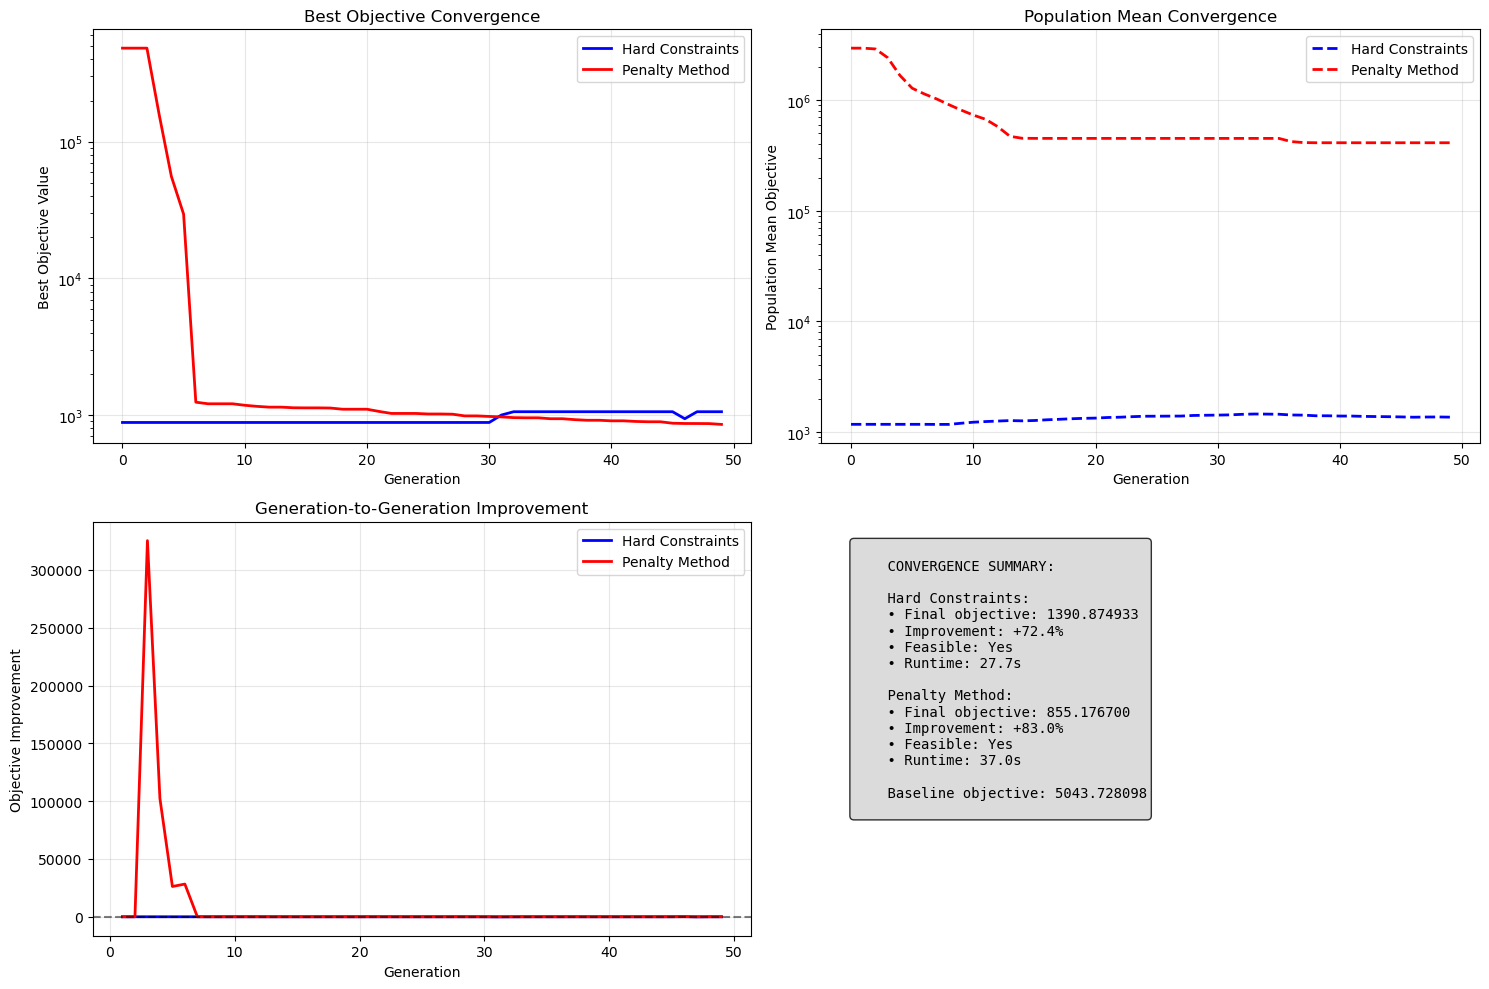

📊 Convergence Analysis:
   Hard constraints converged to: 1058.864105
   Penalty method converged to: 855.176700
   🏃 Penalty method converged faster (gen 49 vs 50)


In [19]:
# Visualize convergence comparison
print("\n📈 CONVERGENCE COMPARISON")
print("="*50)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Get optimization histories
history_hard = result_hard.optimization_history
history_penalty = result_penalty.optimization_history

if history_hard and history_penalty:
    # Extract convergence data
    gen_hard = [h['generation'] for h in history_hard]
    obj_hard = [h['best_objective'] for h in history_hard]
    mean_hard = [h['mean_objective'] for h in history_hard]

    gen_penalty = [h['generation'] for h in history_penalty]
    obj_penalty = [h['best_objective'] for h in history_penalty]
    mean_penalty = [h['mean_objective'] for h in history_penalty]

    # Plot 1: Best objective convergence
    axes[0,0].plot(gen_hard, obj_hard, 'b-', linewidth=2, label='Hard Constraints')
    axes[0,0].plot(gen_penalty, obj_penalty, 'r-', linewidth=2, label='Penalty Method')
    axes[0,0].set_xlabel('Generation')
    axes[0,0].set_ylabel('Best Objective Value')
    axes[0,0].set_title('Best Objective Convergence')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].set_yscale('log')

    # Plot 2: Population mean convergence
    axes[0,1].plot(gen_hard, mean_hard, 'b--', linewidth=2, label='Hard Constraints')
    axes[0,1].plot(gen_penalty, mean_penalty, 'r--', linewidth=2, label='Penalty Method')
    axes[0,1].set_xlabel('Generation')
    axes[0,1].set_ylabel('Population Mean Objective')
    axes[0,1].set_title('Population Mean Convergence')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].set_yscale('log')

    # Plot 3: Improvement rate comparison
    if len(obj_hard) > 1 and len(obj_penalty) > 1:
        improve_hard = [obj_hard[i-1] - obj_hard[i] for i in range(1, len(obj_hard))]
        improve_penalty = [obj_penalty[i-1] - obj_penalty[i] for i in range(1, len(obj_penalty))]

        axes[1,0].plot(gen_hard[1:], improve_hard, 'b-', linewidth=2, label='Hard Constraints')
        axes[1,0].plot(gen_penalty[1:], improve_penalty, 'r-', linewidth=2, label='Penalty Method')
        axes[1,0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[1,0].set_xlabel('Generation')
        axes[1,0].set_ylabel('Objective Improvement')
        axes[1,0].set_title('Generation-to-Generation Improvement')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)

    # Plot 4: Summary statistics
    axes[1,1].axis('off')

    # Calculate final improvements vs baseline
    baseline_obj = objective_hard.evaluate(opt_data['initial_solution'])
    hard_improvement = ((baseline_obj - result_hard.best_objective) / baseline_obj * 100)
    penalty_improvement = ((baseline_obj - result_penalty.best_objective) / baseline_obj * 100)

    summary_text = f"""
    CONVERGENCE SUMMARY:

    Hard Constraints:
    • Final objective: {result_hard.best_objective:.6f}
    • Improvement: {hard_improvement:+.1f}%
    • Feasible: {'Yes' if result_hard.constraint_violations['feasible'] else 'No'}
    • Runtime: {result_hard.optimization_time:.1f}s

    Penalty Method:
    • Final objective: {result_penalty.best_objective:.6f}
    • Improvement: {penalty_improvement:+.1f}%
    • Feasible: {'Yes' if result_penalty.constraint_violations['feasible'] else 'No'}
    • Runtime: {result_penalty.optimization_time:.1f}s

    Baseline objective: {baseline_obj:.6f}
    """

    axes[1,1].text(0.05, 0.95, summary_text, transform=axes[1,1].transAxes,
                   fontsize=10, verticalalignment='top', fontfamily='monospace',
                   bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

    plt.tight_layout()
    plt.show()

    print(f"📊 Convergence Analysis:")
    print(f"   Hard constraints converged to: {obj_hard[-1]:.6f}")
    print(f"   Penalty method converged to: {obj_penalty[-1]:.6f}")

    # Determine which converged faster
    target_obj = min(obj_hard[-1], obj_penalty[-1]) * 1.01  # Within 1% of best

    hard_convergence_gen = next((i for i, obj in enumerate(obj_hard) if obj <= target_obj), len(obj_hard))
    penalty_convergence_gen = next((i for i, obj in enumerate(obj_penalty) if obj <= target_obj), len(obj_penalty))

    if hard_convergence_gen < penalty_convergence_gen:
        print(f"   🏃 Hard constraints converged faster (gen {hard_convergence_gen} vs {penalty_convergence_gen})")
    elif penalty_convergence_gen < hard_convergence_gen:
        print(f"   🏃 Penalty method converged faster (gen {penalty_convergence_gen} vs {hard_convergence_gen})")
    else:
        print(f"   ⚖️ Both methods converged at similar rates")

else:
    print("❌ Convergence history not available for comparison")

You can see that the mean value of the objective function is much higher with the penalty method. This is because infeasible solutions are heavily penalised, so the objective value is higher. This penalisation guides the PSO away from infeasible solutions, and towards feasible solutions.


🗺️ SPATIAL SOLUTIONS COMPARISON


/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:950: UserWarning: Glyph 128652 (\N{BUS}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  ax.figure.canvas.draw_idle()
/home/hussein/miniconda3/envs/transit_opt_env/lib/python3.12/site-packages/geopandas/plotting.py:480: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREN

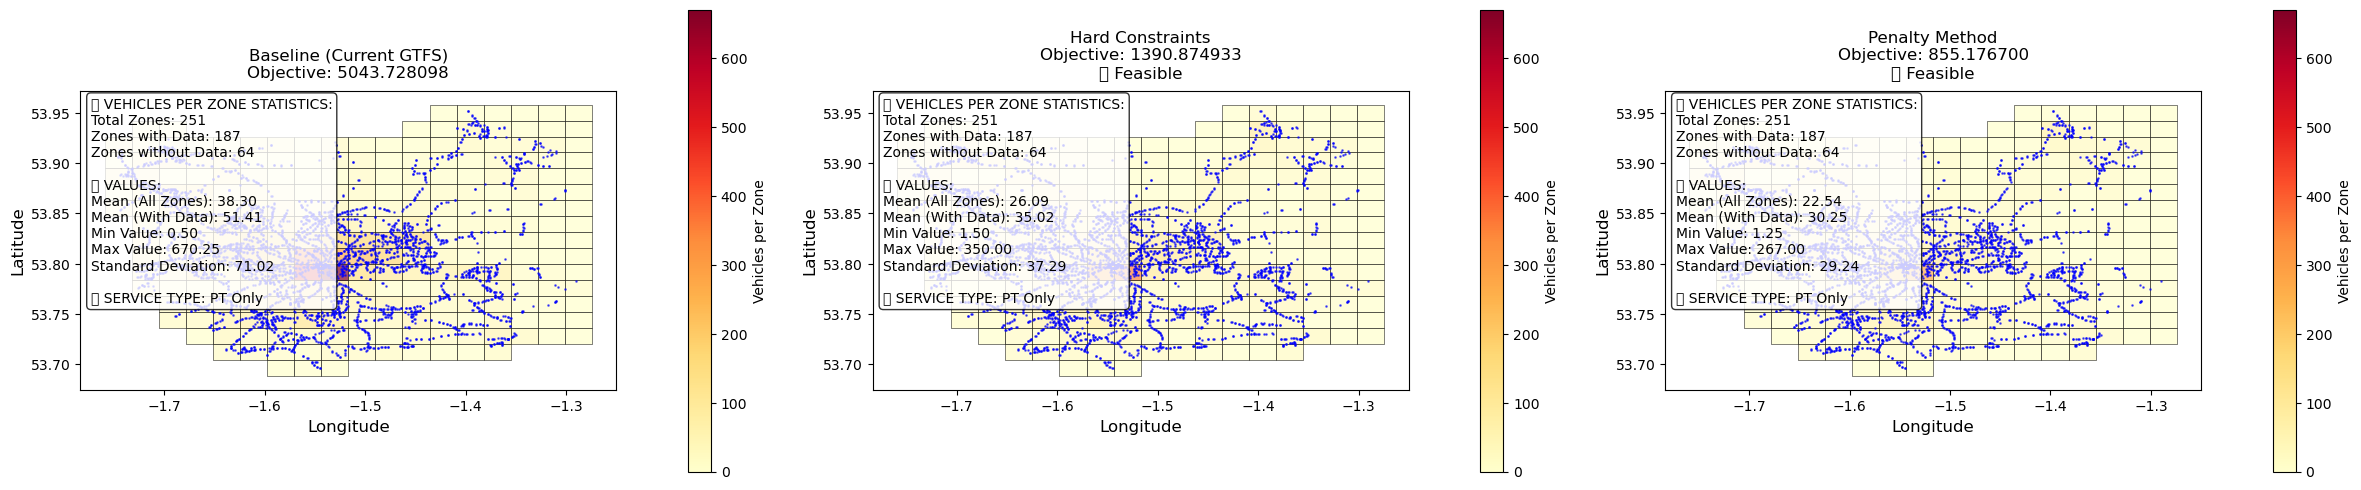


📊 Spatial Equity Comparison:
   Metric               Baseline     Hard Const   Penalty     
   -------------------- ------------ ------------ ------------
   Variance             5043.7281    1390.8749    855.1767    
   Coeff of Var         1.854        1.429        1.297       
   Zones w/ Service     187          187          187         


In [20]:
# Visualize spatial solutions comparison
print("\n🗺️ SPATIAL SOLUTIONS COMPARISON")
print("="*50)

fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Calculate consistent color scale
baseline_vehicles = objective_hard.spatial_system._vehicles_per_zone(
    opt_data['initial_solution'], opt_data
)["average"]

hard_vehicles = objective_hard.spatial_system._vehicles_per_zone(
    result_hard.best_solution, opt_data
)["average"]

penalty_vehicles = objective_penalty.spatial_system._vehicles_per_zone(
    result_penalty.best_solution, opt_data
)["average"]

vmin = 0
vmax = max(baseline_vehicles.max(), hard_vehicles.max(), penalty_vehicles.max())

# Plot 1: Baseline
objective_hard.visualize(
    solution_matrix=opt_data['initial_solution'],
    ax=axes[0],
    show_stops=True,
    vmin=vmin,
    vmax=vmax
)
baseline_obj = objective_hard.evaluate(opt_data['initial_solution'])
axes[0].set_title(f"Baseline (Current GTFS)\nObjective: {baseline_obj:.6f}",
                  fontsize=12, pad=10)

# Plot 2: Hard constraints solution
objective_hard.visualize(
    solution_matrix=result_hard.best_solution,
    ax=axes[1],
    show_stops=True,
    vmin=vmin,
    vmax=vmax
)
feasible_text = "✅ Feasible" if result_hard.constraint_violations['feasible'] else "❌ Infeasible"
axes[1].set_title(f"Hard Constraints\nObjective: {result_hard.best_objective:.6f}\n{feasible_text}",
                  fontsize=12, pad=10)

# Plot 3: Penalty method solution
objective_penalty.visualize(
    solution_matrix=result_penalty.best_solution,
    ax=axes[2],
    show_stops=True,
    vmin=vmin,
    vmax=vmax
)
feasible_text = "✅ Feasible" if result_penalty.constraint_violations['feasible'] else "❌ Infeasible"
axes[2].set_title(f"Penalty Method\nObjective: {result_penalty.best_objective:.6f}\n{feasible_text}",
                  fontsize=12, pad=10)

plt.tight_layout()
plt.show()


# Compare spatial equity metrics
baseline_analysis = objective_hard.get_detailed_analysis(opt_data['initial_solution'])

print(f"\n📊 Spatial Equity Comparison:")
print(f"   {'Metric':<20} {'Baseline':<12} {'Hard Const':<12} {'Penalty':<12}")
print(f"   {'-'*20} {'-'*12} {'-'*12} {'-'*12}")
print(f"   {'Variance':<20} {baseline_analysis['variance_average']:<12.4f} {analysis_hard['variance_average']:<12.4f} {analysis_penalty['variance_average']:<12.4f}")
print(f"   {'Coeff of Var':<20} {baseline_analysis['coefficient_of_variation_average']:<12.3f} {analysis_hard['coefficient_of_variation_average']:<12.3f} {analysis_penalty['coefficient_of_variation_average']:<12.3f}")
print(f"   {'Zones w/ Service':<20} {baseline_analysis['zones_with_service_average']:<12} {analysis_hard['zones_with_service_average']:<12} {analysis_penalty['zones_with_service_average']:<12}")